# Paper Plots

This notebook contains the code for making the plots in the offline analysis paper, EXO-23-002.

In [1]:
import os, sys, glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import mplhep as hep
import math
import warnings
import scipy
from plot_utils import *
import uproot

warnings.filterwarnings('ignore')
hep.style.use("CMS")
matplotlib.rcParams.update({'figure.max_open_warning': 0})
matplotlib.rcParams['figure.facecolor'] = 'white'

In [2]:
## parameters
output_label = '/home/submit/{}/public_html/SUEP/analysis/debug/'.format(os.environ['USER'])
plotDir = '/data/submit/{}/SUEP/outputs/'.format(os.environ['USER'])
outFile = 'data.root'

In [3]:
# create output dir
if not os.path.isdir(output_label): 
    print("Creating", output_label)
    os.mkdir(output_label)

# generate list of files that you want to read histograms for
offline_files_2018 = getHistLists(plotDir, 'unblind', '../filelist/list_2018_JetHT_A02.txt')
offline_files_2017 = getHistLists(plotDir, 'unblind', '../filelist/list_2017_JetHT_A02.txt')
offline_files_2016 = getHistLists(plotDir, 'unblind', '../filelist/list_2016_JetHT_A02.txt')

In [4]:
plots_2018 = loader(offline_files_2018, auto_lumi=True, exclude_low_bins=True)
plots_2017 = loader(offline_files_2017, auto_lumi=True, exclude_low_bins=True)
plots_2016 = loader(offline_files_2016, auto_lumi=True, exclude_low_bins=True)

In [5]:
plots = {}

for key in plots_2018.keys(): plots[key+"_2018"] = plots_2018[key]
for key in plots_2017.keys(): plots[key+"_2017"] = plots_2017[key]
for key in plots_2016.keys(): plots[key+"_2016"] = plots_2016[key]

combineYears(plots, 'data', ['2018', '2017', '2016'])

## ABCD Regions Distribution

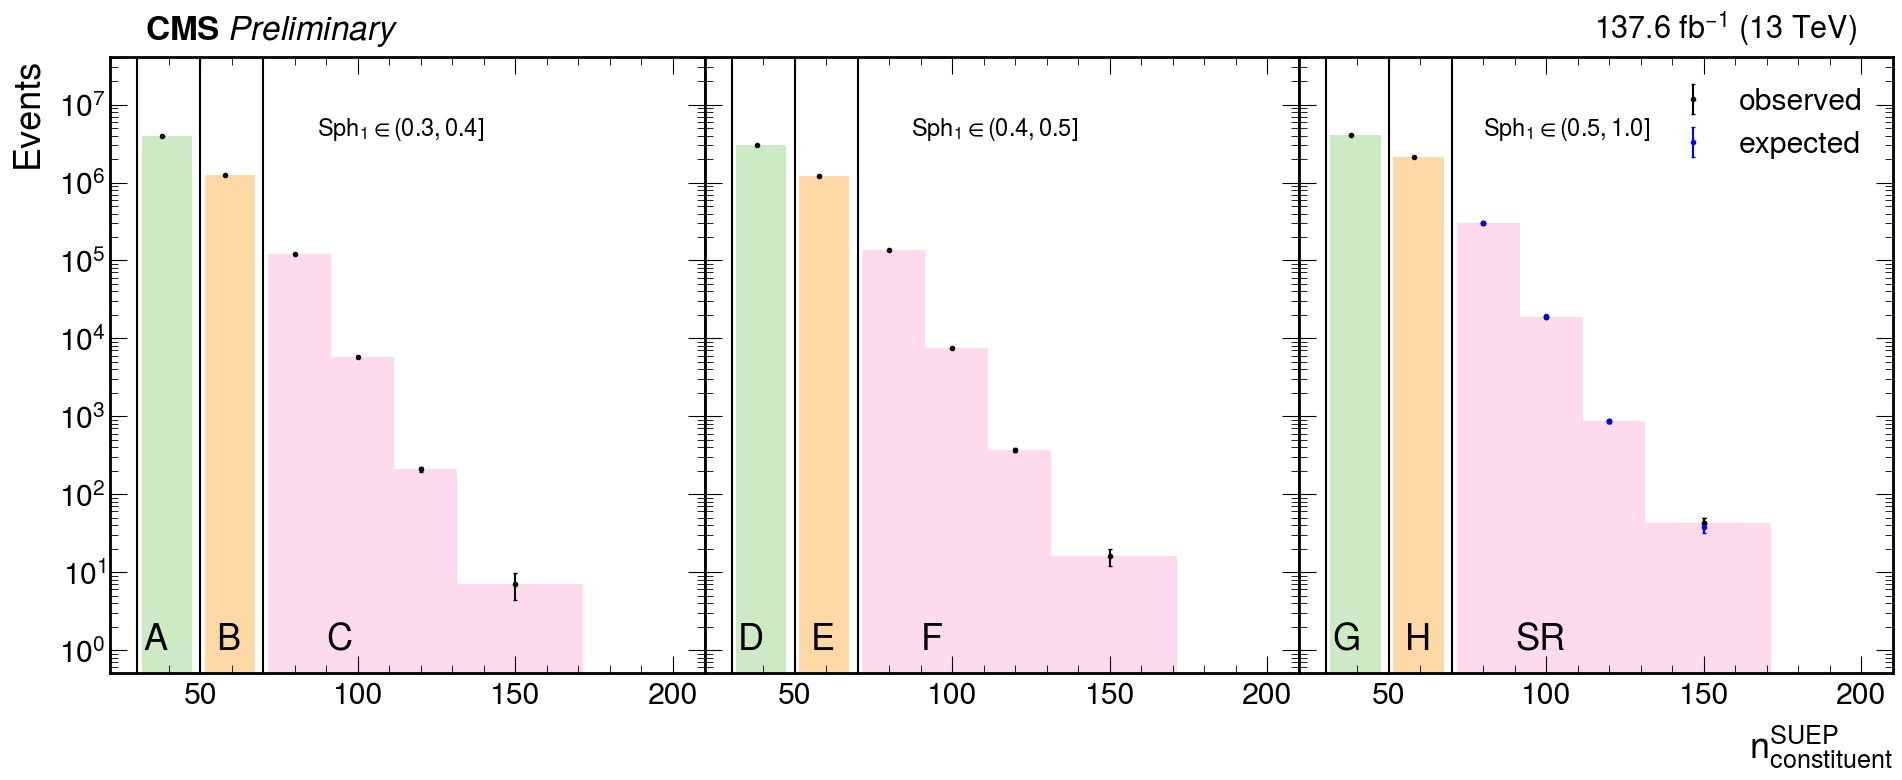

In [12]:
plot_label = '2D_SUEP_S1_vs_SUEP_nconst_Cluster70'
abcd = plots['data_all'][plot_label][::,::] 
xregions = [0.3j, 0.4j, 0.5j, 1.0j]
yregions = [30j, 50j, 70j, 300j]



SR, SR_exp = ABCD_9regions_errorProp(abcd, xregions, yregions, sum_var='x')

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(23, 8), sharey=True,sharex=True) #Plot 3 subplots
fig.subplots_adjust(wspace=0) #Plot 
(ax1, ax2, ax3) = axes

slicing = [30,50,70,200] #The boundary of the ABCD regions 
label_positions = [32,55,90] #The positions of the letters
colormap = plt.cm.get_cmap('Pastel1')
colors = [colormap(0.3),colormap(0.5),colormap(0.8)]

ymax = 0

# Plot the distributions in every region
regions = {'A':(ax1,0),
           'B':(ax1,1),
           'C':(ax1,2),
           'D':(ax2,0),
           'E':(ax2,1),
           'F':(ax2,2),
           'G':(ax3,0),
           'H':(ax3,1),
           'I':(ax3,2)}

with uproot.recreate(outFile) as froot:
    for letter, (axis,i) in regions.items():

        h = plots['data_all'][letter + '_SUEP_nconst_Cluster70']
        h = h[slicing[i]*1j:slicing[i+1]*1j]
        
        if letter not in ['I', 'C', 'F']:
            h = h[::16j]
        else:
            h = rebin_piecewise(h, [70, 90, 110, 130, 170, 200])
            
        if letter == 'I':
            froot['SR_SUEP_nconst'] = h
            letter = 'SR'
        else:
            froot[letter + '_SUEP_nconst'] = h
        
        yerr = h.variances()**0.5 #Take error
        y, x = h.to_numpy()
        axis.stairs(y,x+1.5,fill=True,color=colors[i])
        
        centers = (x + np.roll(x,1))/2
        centers = centers[1:] #centers of bins
        axis.text(label_positions[i],1,str(letter))
        if letter == 'I': continue
        axis.errorbar(centers,y,yerr=yerr,linestyle='',c='black',capsize=1.5,fmt ='.')
        ymax = max(np.append(y,ymax))

    froot['SR_exp_SUEP_const'] = SR_exp[70j:slicing[-1]*1.j]

ax3.errorbar(centers,y,yerr=yerr,linestyle='',c='black',capsize=1.5,fmt ='.',label='observed')
SR_exp = rebin_piecewise(SR_exp, [70, 90, 110, 130, 170, 200])

# get these from the postfit in SUEPLimits
SR_exp_vals = np.array([
    SR_exp.values()[0],
    4550+6050+8830,
    195+294+392,
    7.4+11.3+19,
    0
])
SR_err = np.array([
    np.sqrt(SR_exp.variances()[0]),
    np.sqrt(40**2 + 70**2 + 90**2),
    np.sqrt(8**2 + 15**2 + 19**2),
    np.sqrt(2.4**2 + 2.9**2 + 4**2),
    0
])
ax3.errorbar(centers,SR_exp_vals,yerr=SR_err,linestyle='',c='blue',capsize=1.5,fmt ='.',label ='expected')


#Adjust the figure and add labels 
ytop = ymax *10 # The upper limit for the yaxis
for ax in axes:
    ax.set_yscale('log')
    ax.set_ylim(0.5,ytop)
    ax.vlines([30,50,70],0.5,ytop,color='black') #Take bin edges
    
ax1.set_ylabel('Events',labelpad=10)
ax3.set_xlabel('$n^{SUEP}_{constituent}$', labelpad=10, loc='right')

ax1.text(87,ymax,r'$Sph_{1} \in (0.3,0.4]$',fontsize=17)
ax2.text(87,ymax,r'$Sph_{1} \in (0.4,0.5]$',fontsize=17)
ax3.text(80,ymax,r'$Sph_{1} \in (0.5,1.0]$',fontsize=17)

# ax3.set_xlim([10,220])
plt.legend()

#Add CMS statements
cms = ax.text(
    -345, ytop*1.7, u"CMS $\it{Preliminary}$",
    fontsize=24, fontweight='bold',
)

lumi = ax.text(
    115, ytop*1.7, r"%.1f fb$^{-1}$ ($13$ TeV)" % round(lumiLabel('2016')+lumiLabel('2017')+lumiLabel('2018'),1),
    fontsize=22,
)
fig.tight_layout()
plt.autoscale()

plt.savefig('/home/submit/{}/SUEP/EXO-23-002/images/all_regions.pdf'.format(os.environ['USER']),format='pdf',bbox_inches='tight')

The remaining plots in the paper can be made using the SUEPLimits repo.